# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [193]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from time import gmtime,strftime
from scipy.stats import linregress
from pprint import pprint

# Import API key
from config import weather_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "cities.csv"

# API variables
query_url = "http://api.openweathermap.org/data/2.5/weather?units=imperial&appid=%s&q=" % weather_key

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Plot Generator Functions

In [226]:
def buildLatPlot(y, ylabel, save=False):
    # X limits
    xmin = clean_city_df["Lat"].min()
    xmax = clean_city_df["Lat"].max()
    xlim = getLimits(xmin, xmax, 10)
    
    # Y limits
    ymin = clean_city_df[y].min()
    ymax = clean_city_df[y].max()
    ylim = getLimits(ymin, ymax, 5)
    
    # Create title
    date = strftime("%m/%d/%Y",gmtime())
    title = "City Latitude vs. {0}: {1}".format(ylabel,date)
    
    # Create and show plot
    lat_plt = clean_city_df.plot(kind="scatter", x="Lat", y=y, grid=True,
                       edgecolor="black", facecolor="blue", alpha=.75,
                       xlim=xlim, ylim=ylim, title=title)
    xlabel = "Latitude"
    lat_plt.set_xlabel(xlabel)
    lat_plt.set_ylabel(ylabel)
    plt.show()
    if save is True:
        output_date = strftime("%m%d%Y",gmtime())
        output_ylabel = " ".join(ylabel.split()[:-1])
        lat_plt.figure.savefig("output/{0}_{1}-{2}.png".format(output_date,xlabel,output_ylabel))

In [200]:
# Gets the limits of the chart based on the minimum and maximum values
# The landmark value is what to round to so no plot points are chopped off when the plot renders
def getLimits(in_min,in_max,landmark):
    # get minimum
    if in_min <= 0:
        out_min = in_min-(landmark-(abs(in_min)%landmark))
    else:
        out_min = in_min-(in_min%landmark)
    # get maximum
    if in_max >= 0:
        out_max = in_max+(landmark-(in_max%landmark))
    else:
        out_max = in_max+(abs(in_max)%landmark)
    return (out_min,out_max)

## Generate Cities List

In [79]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

603

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [80]:
# Print title and divider
print_title = "Beginning Data Retrieval"
print(print_title)
print(len(print_title)*"-")

# Request weather data from every city in list
# Instantiate counters and city list
record = 1
rec_set = 1
city_list = []

# Loop through the cities and store the api response
for city in cities:
    response = requests.get(query_url + city).json()
    # if the response doesn't have a name, skip adding it to the city list and do not increment
    try:
        print(f"Processing Record {record} of Set {rec_set} | {response['name']}")
    except KeyError:
        print("City not found. Skipping...")
    else:
        city_list.append(response)
        if record == 50:
            record = 1
            rec_set += 1
        else:
            record += 1
    # Lastly, wait a second before making another call
    finally:
        time.sleep(1)

Beginning Data Retrieval
------------------------
Processing Record 1 of Set 1 | Saint-Philippe
Processing Record 2 of Set 1 | Hamilton
Processing Record 3 of Set 1 | Skagen
Processing Record 4 of Set 1 | Nchelenge
Processing Record 5 of Set 1 | Ribeira Grande
Processing Record 6 of Set 1 | Puerto Ayora
City not found. Skipping...
Processing Record 7 of Set 1 | Udachny
Processing Record 8 of Set 1 | Macao
Processing Record 9 of Set 1 | Castro
Processing Record 10 of Set 1 | Bredasdorp
City not found. Skipping...
Processing Record 11 of Set 1 | Nanortalik
Processing Record 12 of Set 1 | Mezőkeresztes
Processing Record 13 of Set 1 | Yumen
Processing Record 14 of Set 1 | Bafoulabé
Processing Record 15 of Set 1 | La Santisima Trinidad
Processing Record 16 of Set 1 | Avarua
Processing Record 17 of Set 1 | Faya
Processing Record 18 of Set 1 | Ondjiva
Processing Record 19 of Set 1 | Osório
Processing Record 20 of Set 1 | Busselton
Processing Record 21 of Set 1 | Rikitea
Processing Record 22 o

Processing Record 38 of Set 4 | Ouégoa
Processing Record 39 of Set 4 | Jutaí
Processing Record 40 of Set 4 | Tromsø
Processing Record 41 of Set 4 | Ubari
City not found. Skipping...
Processing Record 42 of Set 4 | East London
Processing Record 43 of Set 4 | Yabēlo
Processing Record 44 of Set 4 | Jumla
Processing Record 45 of Set 4 | Boyolangu
Processing Record 46 of Set 4 | Ancud
Processing Record 47 of Set 4 | Iqaluit
Processing Record 48 of Set 4 | Skibbereen
Processing Record 49 of Set 4 | Lüderitz
Processing Record 50 of Set 4 | Nhlangano
Processing Record 1 of Set 5 | Ostrovnoy
Processing Record 2 of Set 5 | Saint George
Processing Record 3 of Set 5 | Chui
City not found. Skipping...
City not found. Skipping...
Processing Record 4 of Set 5 | Mount Gambier
City not found. Skipping...
Processing Record 5 of Set 5 | Hasaki
Processing Record 6 of Set 5 | Karratha
Processing Record 7 of Set 5 | Campina Grande do Sul
Processing Record 8 of Set 5 | Kaeo
Processing Record 9 of Set 5 | Láz

Processing Record 17 of Set 8 | Balad
Processing Record 18 of Set 8 | Chabahar
Processing Record 19 of Set 8 | Kefamenanu
Processing Record 20 of Set 8 | Baculin
Processing Record 21 of Set 8 | Luganville
Processing Record 22 of Set 8 | Port Macquarie
City not found. Skipping...
Processing Record 23 of Set 8 | Sapele
Processing Record 24 of Set 8 | Tual
Processing Record 25 of Set 8 | Winnemucca
Processing Record 26 of Set 8 | Bulgan
City not found. Skipping...
Processing Record 27 of Set 8 | Conde
Processing Record 28 of Set 8 | Maumere
Processing Record 29 of Set 8 | Gīdolē
Processing Record 30 of Set 8 | Illela
Processing Record 31 of Set 8 | Rawson
Processing Record 32 of Set 8 | Ballymena
Processing Record 33 of Set 8 | Kostomuksha
Processing Record 34 of Set 8 | Khasan
Processing Record 35 of Set 8 | Cabedelo
Processing Record 36 of Set 8 | Vestmannaeyjar
Processing Record 37 of Set 8 | Nsanje
Processing Record 38 of Set 8 | Gaur
City not found. Skipping...
Processing Record 39 o

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [81]:
# Create empty dictionary to add api data to
cities_df = {}

# Add City, Lat, Long, Max Temp, Humidity, Cloudiness, Wind Speed, Country, and Date
# Create empty lists for each soon-to-be column
cities_df["City"], cities_df["Lat"], cities_df["Lng"], cities_df["Max Temp"], cities_df["Humidity"], cities_df["Cloudiness"], cities_df["Wind Speed"], cities_df["Country"], cities_df["Date"] = ([] for x in range(9))
for i in range(len(city_list)):
    cities_df["City"].append(city_list[i]["name"])
    cities_df["Lat"].append(city_list[i]["coord"]["lat"])
    cities_df["Lng"].append(city_list[i]["coord"]["lon"])
    cities_df["Max Temp"].append(city_list[i]["main"]["temp_max"])
    cities_df["Humidity"].append(city_list[i]["main"]["humidity"])
    cities_df["Cloudiness"].append(city_list[i]["clouds"]["all"])
    cities_df["Wind Speed"].append(city_list[i]["wind"]["speed"])
    cities_df["Country"].append(city_list[i]["sys"]["country"])
    cities_df["Date"].append(city_list[i]["dt"])
cities_df = pd.DataFrame(cities_df)
cities_df.to_csv("output/cities.csv")
cities_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Saint-Philippe,-21.36,55.77,79.00,65,75,21.92,RE,1609257532
1,Hamilton,39.18,-84.53,33.01,63,75,6.93,US,1609257319
2,Skagen,57.72,10.58,41.00,91,100,11.99,DK,1609257534
3,Nchelenge,-9.35,28.73,74.07,78,99,0.36,ZM,1609257535
4,Ribeira Grande,38.52,-28.70,59.00,58,40,16.11,PT,1609257536


In [82]:
cities_df.describe()

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,5.460000e+02
mean,17.849322,16.387894,53.577234,71.789377,52.948718,8.647088,1.609258e+09
std,33.241691,88.827495,32.284815,20.798676,38.544400,5.936304,2.095224e+02
min,-54.800000,-175.200000,-51.180000,9.000000,0.000000,0.310000,1.609257e+09
25%,-9.062500,-61.532500,32.402500,61.000000,13.250000,4.187500,1.609258e+09
50%,18.760000,18.380000,64.020000,77.000000,62.500000,7.730000,1.609258e+09
75%,45.215000,89.765000,78.800000,87.000000,90.000000,11.410000,1.609258e+09
max,78.220000,179.320000,101.350000,100.000000,100.000000,50.550000,1.609258e+09


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [83]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
clean_city_df = cities_df.loc[cities_df["Humidity"] <= 100, :]
clean_city_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Saint-Philippe,-21.36,55.77,79.00,65,75,21.92,RE,1609257532
1,Hamilton,39.18,-84.53,33.01,63,75,6.93,US,1609257319
2,Skagen,57.72,10.58,41.00,91,100,11.99,DK,1609257534
3,Nchelenge,-9.35,28.73,74.07,78,99,0.36,ZM,1609257535
4,Ribeira Grande,38.52,-28.70,59.00,58,40,16.11,PT,1609257536


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

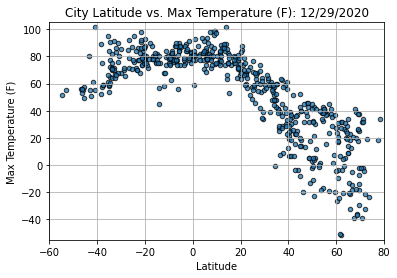

In [221]:
buildLatPlot("Max Temp","Max Temperature (F)",save=True)

## Latitude vs. Humidity Plot

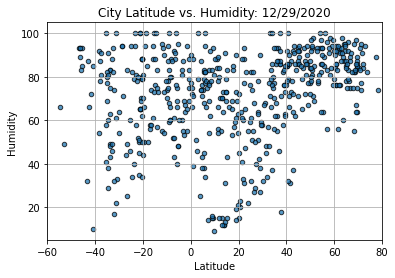

In [222]:
buildLatPlot("Humidity","Humidity",save=True)

## Latitude vs. Cloudiness Plot

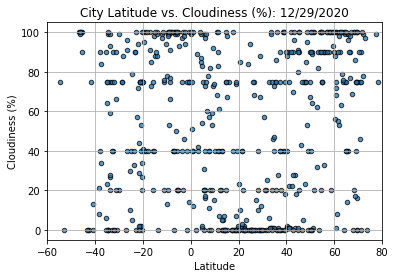

In [223]:
buildLatPlot("Cloudiness","Cloudiness (%)",save=True)

## Latitude vs. Wind Speed Plot

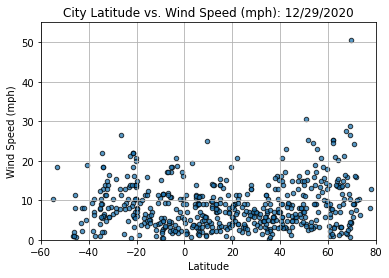

In [224]:
buildLatPlot("Wind Speed","Wind Speed (mph)",save=True)

## Linear Regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.46937863826630627


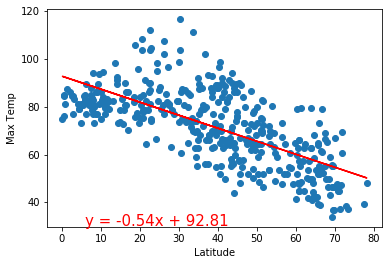

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.6082708688906918


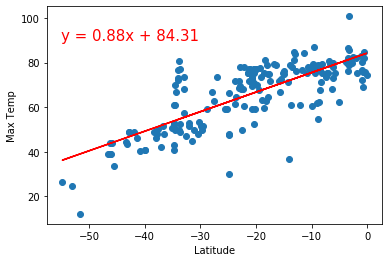

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.000543987878808455


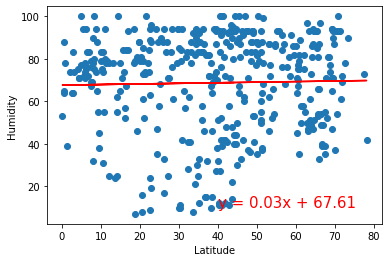

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.014985174297345524


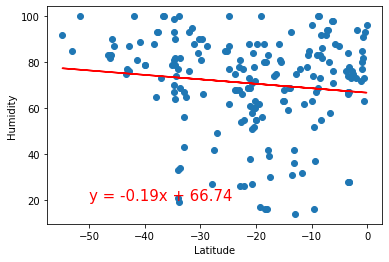

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.0020898727664228514


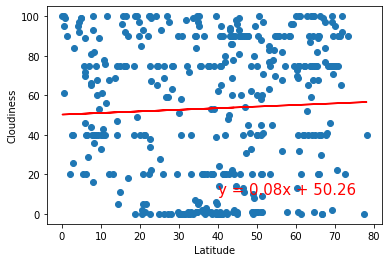

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.0035263772085582894


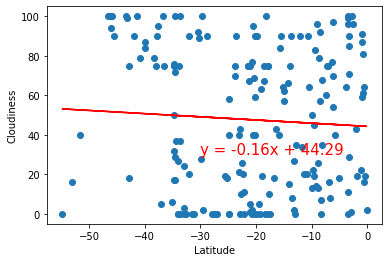

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.04019723576144484


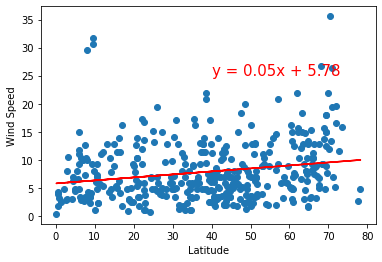

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.017128274759839232


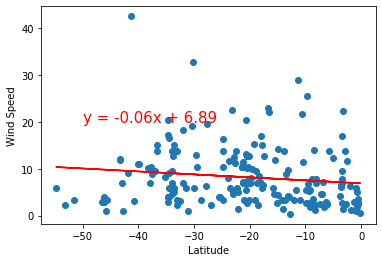